In [1]:
# df_players
# name, elo, state (H/m), move time avg (not possible yet), acpl game avg
# df_games
# p1_ID, p2_ID, winner_ID, date, opening, p1_ELO, p2_ELO
# df_moves
# player_ID, game_ID, time, eval, fen/move, comment

In [1]:
import pandas as pd
import numpy as np

import chess
import chess.pgn
from stockfish import Stockfish
import os

%load_ext autoreload
%autoreload 2

In [8]:
#stockfish = Stockfish(
#    'stockfish_14_linux_x64/stockfish_14_linux_x64/stockfish_14_x64', 
#    parameters={"Threads": 2, 'Min Split Depth': 26, 'Ponder':True}
#)
#stockfish.set_elo_rating(2600)
#stockfish.set_skill_level(30)

In [23]:
%%time

players = {
    'White':[],
    'White_Elo': [],
    'Black': [],
    'Black_Elo': [],
    'WhiteIsComp':[],
}

games = {
    'Game_ID': [],
    'Date' : [],
    'White':[],  # Dummy ID
    'White_Elo': [],
    'Black': [],  # Dummy ID
    'Black_Elo': [],
    'ECO': [],
    'Result': [],
}

moves_log_dict = {
    'Game_ID': [],
    'FEN_moves': [],
    'Bitmap_moves': [],
    #'cpl': [],
    'WhiteIsComp': [],
    'turn': [],
    'Castling_right': [],
    'EP_option': [],
    'Pseudo_EP_option': [],
    'Halfmove_clock': []
    #'Result': [],
}

# Set list of Pieces
PIECES = [chess.Piece.from_symbol('P'),
         chess.Piece.from_symbol('N'),
         chess.Piece.from_symbol('B'),
         chess.Piece.from_symbol('R'),
         chess.Piece.from_symbol('Q'),
         chess.Piece.from_symbol('K'),
         chess.Piece.from_symbol('p'),
         chess.Piece.from_symbol('n'),
         chess.Piece.from_symbol('b'),
         chess.Piece.from_symbol('r'),
         chess.Piece.from_symbol('q'),
         chess.Piece.from_symbol('k')]

# read file
pgn = open("/Users/manuel/code/VPeron/cc_detector/raw_data/Fics_data_pc_data.pgn", encoding='UTF-8')  # always a Comp vs Player
game_counter = 0

while True:  # keep reading games
    try:
        game = chess.pgn.read_game(pgn)
        board = game.board()
        moves = list(game.mainline_moves())
        
        if len(moves) > 5:
            # Player
            players['White_Elo'].append(game.headers['WhiteElo'])
            players['Black_Elo'].append(game.headers['BlackElo'])
            players['White'].append(game.headers['White'])
            players['Black'].append(game.headers['Black'])
            players['WhiteIsComp'].append(game.headers.get('WhiteIsComp', 'No'))

            # Games
            games['Game_ID'].append(game.headers['FICSGamesDBGameNo'])
            games['White'].append(game.headers['White'])  # dummy ID
            games['Black'].append(game.headers['Black'])  # dummy ID
            games['White_Elo'].append(game.headers['WhiteElo'])
            games['Black_Elo'].append(game.headers['BlackElo'])
            games['ECO'].append(game.headers['ECO'])
            games['Result'].append(game.headers['Result'])
            games['Date'].append(game.headers['Date'])

            # MOVE CYCLE
            white = True
            for move in moves:
                board.push(move)
                #fen_pos.append(board.fen())
                #stockfish.set_fen_position(board.fen())  # load stockfish with current FEN for eval
                #cpl = stockfish.get_evaluation()['value']/100

                moves_log_dict['Game_ID'].append(game.headers['FICSGamesDBGameNo'])
                moves_log_dict['FEN_moves'].append(board.fen())

                #Generate bitmap representation of FENs
                bitmap_board_dict = {}
                positions = board.piece_map()

                for piece in PIECES:
                    bitmap_board = {}
                    for position in positions:
                        if positions[position] == piece: 
                            bitmap_board[position] = 1
                        else:
                            bitmap_board[position] = 0
                    bitmap_board_dict[str(piece)] = bitmap_board            

                moves_log_dict['Bitmap_moves'].append(bitmap_board_dict)

                #moves_log_dict['cpl'].append(cpl)

                #Turn color and castling availablity
                moves_log_dict['WhiteIsComp'].append(game.headers.get('WhiteIsComp', 'No'))
                if white:
                    moves_log_dict['turn'].append('white')
                    moves_log_dict['Castling_right'].append(int(board.has_castling_rights(chess.WHITE)))
                    white = False
                else:
                    moves_log_dict['turn'].append('black')
                    moves_log_dict['Castling_right'].append(int(board.has_castling_rights(chess.BLACK)))
                    white = True

                #(Pseudo) en passant opportunity
                moves_log_dict['EP_option'].append(int(board.has_legal_en_passant()))
                moves_log_dict['Pseudo_EP_option'].append(int(board.has_pseudo_legal_en_passant()))

                #Halfmove clock
                moves_log_dict['Halfmove_clock'].append(board.halfmove_clock)
            
        game_counter += 1
        if game_counter == 1000:  # number of games to read
            break
    except AttributeError:  # no further games to read
        print('No further games to load.')
        break

print(f'{game_counter} games read.')
#TODO takes ~1 sec to process 5 games, too slow.

1000 games read.
CPU times: user 25.9 s, sys: 946 ms, total: 26.8 s
Wall time: 27.6 s


In [31]:
("BlackIsComp" or "WhiteIsComp") in game.headers.keys()

True

In [58]:
df_players = pd.DataFrame(players)
#TODO player ID
df_players.head()

,White,White_Elo,Black,Black_Elo,WhiteIsComp
0,forlat,1970,Geforce,2204,Yes
1,Geforce,2201,forlat,1973,No
2,forlat,1976,Geforce,2198,Yes
3,Geforce,2211,forlat,1963,No
4,forlat,1958,Geforce,2216,Yes


In [59]:
df_games = pd.DataFrame(games)
#TODO game ID
#TODO date to datetime
df_games.head()

,Game_ID,Date,White,White_Elo,Black,Black_Elo,ECO,Result
0,490373548,2021.01.31,forlat,1970,Geforce,2204,A01,0-1
1,490373541,2021.01.31,Geforce,2201,forlat,1973,B00,1-0
2,490373526,2021.01.31,forlat,1976,Geforce,2198,A20,0-1
3,490373517,2021.01.31,Geforce,2211,forlat,1963,B10,0-1
4,490373487,2021.01.31,forlat,1958,Geforce,2216,D30,1/2-1/2


In [60]:
df_moves = pd.DataFrame(moves_log_dict)
#TODO moves and cpl as features when loading to DB
#TODO game ID from df_games
df_moves.head()

,Game_ID,FEN_moves,Bitmap_moves,WhiteIsComp,turn,Castling_right,EP_option,Pseudo_EP_option,Halfmove_clock
0,490373548,rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR ...,"{'P': {63: 0, 62: 0, 61: 0, 60: 0, 59: 0, 58: ...",Yes,white,1,0,0,0
1,490373548,rnbqkbnr/pppp1ppp/8/4p3/8/1P6/P1PPPPPP/RNBQKBN...,"{'P': {63: 0, 62: 0, 61: 0, 60: 0, 59: 0, 58: ...",Yes,black,1,0,0,0
2,490373548,rnbqkbnr/pppp1ppp/8/4p3/8/1PN5/P1PPPPPP/R1BQKB...,"{'P': {63: 0, 62: 0, 61: 0, 60: 0, 59: 0, 58: ...",Yes,white,1,0,0,1
3,490373548,r1bqkbnr/pppp1ppp/2n5/4p3/8/1PN5/P1PPPPPP/R1BQ...,"{'P': {63: 0, 62: 0, 61: 0, 60: 0, 59: 0, 58: ...",Yes,black,1,0,0,2
4,490373548,r1bqkbnr/pppp1ppp/2n5/4p3/8/1PN1P3/P1PP1PPP/R1...,"{'P': {63: 0, 62: 0, 61: 0, 60: 0, 59: 0, 58: ...",Yes,white,1,0,0,0


In [61]:
#id_list1 = df_moves["Game_ID"].unique()
#id_list2 = df_games["Game_ID"].unique()
#missing = list(set(id_list2) - set(id_list1))
#missing

In [62]:
#df_games[df_games["Game_ID"].isin(missing)]

In [54]:
pgn2 = open("../raw_data/Fics_data_pc_data.pgn", encoding='UTF-8')  # always a Comp vs Player

game_string_list = []
game_counter = 0

while True: 
    
    game = chess.pgn.read_game(pgn2)
    game_string = str(game)
    game_string_list.append(game_string)
    
    game_counter += 1
    if game_counter == 100:  # number of games to read        
        break

print(game_string_list[0])

[Event "FICS rated standard game"]
[Site "FICS freechess.org"]
[Date "2021.01.30"]
[Round "?"]
[White "Abysses"]
[Black "Ibrahimsarabaan"]
[Result "1-0"]
[BlackClock "0:15:00.000"]
[BlackElo "1500"]
[BlackRD "0.0"]
[ECO "A00"]
[FICSGamesDBGameNo "490360601"]
[PlyCount "0"]
[Time "21:50:00"]
[TimeControl "900+0"]
[WhiteClock "0:15:00.000"]
[WhiteElo "2795"]
[WhiteIsComp "Yes"]
[WhiteRD "0.0"]

{ Black resigns } 1-0


# search

In [10]:
def search_df(df, column, value):
    try:
        index = np.where(df[column] == value)
        df = df.iloc[index]
        if len(df) == 0:
            return f'No games found for {value}.'
        return df
    except KeyError as e:
        print(e, f'not found.')

In [11]:
search_df(df_moves, 'ECO', 'A01')

,Game_ID,White,Black,ECO,FEN_moves,WhiteIsComp,Result
0,490373548,forlat,Geforce,A01,[rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR...,Yes,0-1
13,490373289,forlat,Geforce,A01,[rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR...,Yes,0-1
23,490373047,forlat,Geforce,A01,[rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR...,Yes,0-1


In [74]:
move1 = chess.Move.from_uci(uci="g8f6")
move1

Move.from_uci('g8f6')

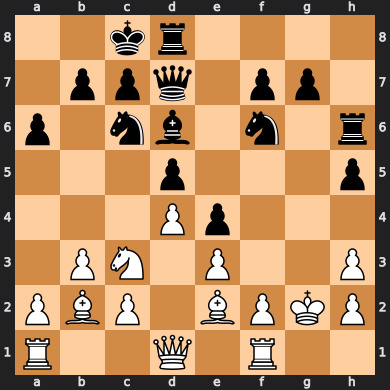

In [268]:
move = df_moves["FEN_moves"][23]
board = chess.Board(move)
board

In [79]:
board.lan(move=move1)

'Ng8-f6'

In [135]:
positions = board.piece_map()

In [137]:
PIECES = list(set((val) for val in positions.values()))
PIECES

[Piece.from_symbol('P'),
 Piece.from_symbol('N'),
 Piece.from_symbol('B'),
 Piece.from_symbol('R'),
 Piece.from_symbol('Q'),
 Piece.from_symbol('K'),
 Piece.from_symbol('p'),
 Piece.from_symbol('n'),
 Piece.from_symbol('b'),
 Piece.from_symbol('r'),
 Piece.from_symbol('q'),
 Piece.from_symbol('k')]

In [38]:
SQUARES = [i for i in range(64)]

In [49]:
bitmap_board_dict = {}

for piece in PIECES:
    bitmap_board = {}
    for square in SQUARES:
        if square in positions.keys():
            if positions[square] == piece: 
                bitmap_board[square] = 1
            else:
                bitmap_board[square] = 0
        else:
            bitmap_board[square] = 0
    bitmap_board_dict[str(piece)] = bitmap_board

In [50]:
bitmap_board_dict

{'P': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 0,
  12: 0,
  13: 0,
  14: 0,
  15: 0,
  16: 0,
  17: 0,
  18: 0,
  19: 0,
  20: 0,
  21: 0,
  22: 1,
  23: 0,
  24: 0,
  25: 0,
  26: 0,
  27: 0,
  28: 0,
  29: 0,
  30: 1,
  31: 1,
  32: 0,
  33: 0,
  34: 0,
  35: 0,
  36: 0,
  37: 0,
  38: 0,
  39: 0,
  40: 0,
  41: 0,
  42: 0,
  43: 0,
  44: 0,
  45: 0,
  46: 0,
  47: 0,
  48: 0,
  49: 0,
  50: 0,
  51: 0,
  52: 0,
  53: 0,
  54: 0,
  55: 0,
  56: 0,
  57: 0,
  58: 0,
  59: 0,
  60: 0,
  61: 0,
  62: 0,
  63: 0},
 'N': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 0,
  12: 0,
  13: 0,
  14: 0,
  15: 0,
  16: 0,
  17: 0,
  18: 0,
  19: 0,
  20: 0,
  21: 0,
  22: 0,
  23: 0,
  24: 0,
  25: 0,
  26: 0,
  27: 0,
  28: 0,
  29: 0,
  30: 0,
  31: 0,
  32: 0,
  33: 0,
  34: 0,
  35: 0,
  36: 0,
  37: 0,
  38: 0,
  39: 0,
  40: 0,
  41: 0,
  42: 0,
  43: 0,
  44: 0,
  45: 0,
  46: 0,
  47: 0,
 

# Data import with package

In [2]:
from cc_detector import data

In [3]:
player_df2, game_df2, move_df2 = data.ChessData().import_data(data_path='../raw_data/Fics_data_pc_data.pgn', 
                                                              import_lim=50)


50 games read.


In [4]:
move_df2

,Game_ID,FEN_moves,Bitmap_moves,WhiteIsComp,turn,Castling_right,EP_option,Pseudo_EP_option,Halfmove_clock
0,490373548,rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR ...,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,white,1,0,0,0
1,490373548,rnbqkbnr/pppp1ppp/8/4p3/8/1P6/P1PPPPPP/RNBQKBN...,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,black,1,0,0,0
2,490373548,rnbqkbnr/pppp1ppp/8/4p3/8/1PN5/P1PPPPPP/R1BQKB...,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,white,1,0,0,1
3,490373548,r1bqkbnr/pppp1ppp/2n5/4p3/8/1PN5/P1PPPPPP/R1BQ...,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,black,1,0,0,2
4,490373548,r1bqkbnr/pppp1ppp/2n5/4p3/8/1PN1P3/P1PP1PPP/R1...,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,white,1,0,0,0
...,...,...,...,...,...,...,...,...,...
2672,490368781,8/5pk1/4p2p/6p1/p2K2PP/3B2P1/1r6/8 b - - 1 41,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,white,0,0,0,1
2673,490368781,8/5pk1/4p2p/6p1/3K2PP/p2B2P1/1r6/8 w - - 0 42,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,black,0,0,0,0
2674,490368781,8/5pk1/4p2p/6p1/6PP/p1KB2P1/1r6/8 b - - 1 42,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,white,0,0,0,1
2675,490368781,8/5pk1/1r2p2p/6p1/6PP/p1KB2P1/8/8 w - - 2 43,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,black,0,0,0,2


## Binary vector representation for board

In [153]:
df_test = pd.DataFrame(move_df2['Bitmap_moves'][0])

In [183]:
df_test 

,P,N,B,R,Q,K,p,n,b,r,q,k
0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
59,0,0,0,0,0,0,0,0,0,0,1,0
60,0,0,0,0,0,0,0,0,0,0,0,1
61,0,0,0,0,0,0,0,0,1,0,0,0
62,0,0,0,0,0,0,0,1,0,0,0,0


In [158]:
np_test = df_test.to_numpy()
np_test

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0,

In [160]:
array_wide = np_test.flatten('F')

In [167]:
dict_wide = {}

for index1, i in enumerate(df_test.columns):
    for index2, j in enumerate(df_test.index):
        dict_wide[str(i)+str(j)] = [df_test.iloc[index2, index1]]

In [164]:
headers = []

for i in df_test.columns:
    for j in df_test.index:
        headers.append(str(i)+str(j))
        
headers

['P0',
 'P1',
 'P2',
 'P3',
 'P4',
 'P5',
 'P6',
 'P7',
 'P8',
 'P9',
 'P10',
 'P11',
 'P12',
 'P13',
 'P14',
 'P15',
 'P16',
 'P17',
 'P18',
 'P19',
 'P20',
 'P21',
 'P22',
 'P23',
 'P24',
 'P25',
 'P26',
 'P27',
 'P28',
 'P29',
 'P30',
 'P31',
 'P32',
 'P33',
 'P34',
 'P35',
 'P36',
 'P37',
 'P38',
 'P39',
 'P40',
 'P41',
 'P42',
 'P43',
 'P44',
 'P45',
 'P46',
 'P47',
 'P48',
 'P49',
 'P50',
 'P51',
 'P52',
 'P53',
 'P54',
 'P55',
 'P56',
 'P57',
 'P58',
 'P59',
 'P60',
 'P61',
 'P62',
 'P63',
 'N0',
 'N1',
 'N2',
 'N3',
 'N4',
 'N5',
 'N6',
 'N7',
 'N8',
 'N9',
 'N10',
 'N11',
 'N12',
 'N13',
 'N14',
 'N15',
 'N16',
 'N17',
 'N18',
 'N19',
 'N20',
 'N21',
 'N22',
 'N23',
 'N24',
 'N25',
 'N26',
 'N27',
 'N28',
 'N29',
 'N30',
 'N31',
 'N32',
 'N33',
 'N34',
 'N35',
 'N36',
 'N37',
 'N38',
 'N39',
 'N40',
 'N41',
 'N42',
 'N43',
 'N44',
 'N45',
 'N46',
 'N47',
 'N48',
 'N49',
 'N50',
 'N51',
 'N52',
 'N53',
 'N54',
 'N55',
 'N56',
 'N57',
 'N58',
 'N59',
 'N60',
 'N61',
 'N62',
 'N6

In [8]:
dict_wide

{'P0': [0],
 'P1': [0],
 'P2': [0],
 'P3': [0],
 'P4': [0],
 'P5': [0],
 'P6': [0],
 'P7': [0],
 'P8': [1],
 'P9': [0],
 'P10': [1],
 'P11': [1],
 'P12': [1],
 'P13': [1],
 'P14': [1],
 'P15': [1],
 'P16': [0],
 'P17': [1],
 'P18': [0],
 'P19': [0],
 'P20': [0],
 'P21': [0],
 'P22': [0],
 'P23': [0],
 'P24': [0],
 'P25': [0],
 'P26': [0],
 'P27': [0],
 'P28': [0],
 'P29': [0],
 'P30': [0],
 'P31': [0],
 'P32': [0],
 'P33': [0],
 'P34': [0],
 'P35': [0],
 'P36': [0],
 'P37': [0],
 'P38': [0],
 'P39': [0],
 'P40': [0],
 'P41': [0],
 'P42': [0],
 'P43': [0],
 'P44': [0],
 'P45': [0],
 'P46': [0],
 'P47': [0],
 'P48': [0],
 'P49': [0],
 'P50': [0],
 'P51': [0],
 'P52': [0],
 'P53': [0],
 'P54': [0],
 'P55': [0],
 'P56': [0],
 'P57': [0],
 'P58': [0],
 'P59': [0],
 'P60': [0],
 'P61': [0],
 'P62': [0],
 'P63': [0],
 'N0': [0],
 'N1': [1],
 'N2': [0],
 'N3': [0],
 'N4': [0],
 'N5': [0],
 'N6': [1],
 'N7': [0],
 'N8': [0],
 'N9': [0],
 'N10': [0],
 'N11': [0],
 'N12': [0],
 'N13': [0],
 'N14'

In [168]:
df_1 = pd.DataFrame(dict_wide)
df_1

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,k54,k55,k56,k57,k58,k59,k60,k61,k62,k63
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [169]:
df_2 = pd.DataFrame(array_wide.reshape(1,-1), columns=headers)
df_2

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,k54,k55,k56,k57,k58,k59,k60,k61,k62,k63
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [180]:
df_check = df_1 == df_2
df_check.iloc[0,:].unique()

array([ True])

In [190]:
boards = []
for line in range(len(move_df2['Bitmap_moves'])):
    df_board = pd.DataFrame(move_df2['Bitmap_moves'][line]).to_numpy()
    array_wide = df_board.flatten('F')
    boards.append(array_wide.reshape(1, -1))

pd.DataFrame(np.concatenate(boards), columns=headers)

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,k54,k55,k56,k57,k58,k59,k60,k61,k62,k63
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2673,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2674,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2675,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


# Create Input and Target arrays for the model

In [194]:
from cc_detector.move import binary_board_df

In [196]:
%%time

df_wide = binary_board_df(move_df2)

CPU times: user 2.18 s, sys: 14.2 ms, total: 2.19 s
Wall time: 2.19 s


In [64]:
df_wide

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,k54,k55,k56,k57,k58,k59,k60,k61,k62,k63
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2673,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2674,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2675,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [135]:
game_infos = move_df2[["Game_ID", "turn", "WhiteIsComp", "Castling_right", "EP_option", "Halfmove_clock"]]
game_infos

,Game_ID,turn,WhiteIsComp,Castling_right,EP_option,Halfmove_clock
0,490373548,white,Yes,1,0,0
1,490373548,black,Yes,1,0,0
2,490373548,white,Yes,1,0,1
3,490373548,black,Yes,1,0,2
4,490373548,white,Yes,1,0,0
...,...,...,...,...,...,...
2672,490368781,white,Yes,0,0,1
2673,490368781,black,Yes,0,0,0
2674,490368781,white,Yes,0,0,1
2675,490368781,black,Yes,0,0,2


In [136]:
df_wide_full = df_wide.join(game_infos)
df_wide_full 

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,k60,k61,k62,k63,Game_ID,turn,WhiteIsComp,Castling_right,EP_option,Halfmove_clock
0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,490373548,white,Yes,1,0,0
1,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,490373548,black,Yes,1,0,0
2,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,490373548,white,Yes,1,0,1
3,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,490373548,black,Yes,1,0,2
4,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,490373548,white,Yes,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,490368781,white,Yes,0,0,1
2673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,490368781,black,Yes,0,0,0
2674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,490368781,white,Yes,0,0,1
2675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,490368781,black,Yes,0,0,2


## Generate binary Computer variable

In [137]:
df_wide_full["Computer"] = df_wide_full.apply(
    lambda x: 1 if (
        (x["WhiteIsComp"] == "Yes") and (x["turn"] == "white")
    ) or (
        (x["WhiteIsComp"] == "No") and (x["turn"] == "black")
    ) else 0, 
    axis=1)

In [138]:
df_wide_full

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,k61,k62,k63,Game_ID,turn,WhiteIsComp,Castling_right,EP_option,Halfmove_clock,Computer
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,0,1
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,black,Yes,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,1,1
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,black,Yes,1,0,2,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,white,Yes,0,0,1,1
2673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,black,Yes,0,0,0,0
2674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,white,Yes,0,0,1,1
2675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,black,Yes,0,0,2,0


## Scaling

In [139]:
from sklearn.preprocessing import MinMaxScaler

In [140]:
scaler = MinMaxScaler()

df_wide_full["Halfmove_clock"] = scaler.fit_transform(df_wide_full[["Halfmove_clock"]])

In [141]:
df_wide_full

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,k61,k62,k63,Game_ID,turn,WhiteIsComp,Castling_right,EP_option,Halfmove_clock,Computer
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,0.000000,1
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,black,Yes,1,0,0.000000,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,0.021277,1
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,black,Yes,1,0,0.042553,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,white,Yes,0,0,0.021277,1
2673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,black,Yes,0,0,0.000000,0
2674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,white,Yes,0,0,0.021277,1
2675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,black,Yes,0,0,0.042553,0


## Generate target vector

In [142]:
y = df_wide_full.groupby(by=["Game_ID", "turn"], sort=False).agg(min)["Computer"].values

In [143]:
y.shape

(100,)

In [144]:
y

array([1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0])

## Split df into white and black games

In [145]:
df_white = df_wide_full[df_wide_full["turn"] == "white"]
df_white

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,k61,k62,k63,Game_ID,turn,WhiteIsComp,Castling_right,EP_option,Halfmove_clock,Computer
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,0.000000,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,0.021277,1
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,0.000000,1
6,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,0.042553,1
8,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,0.021277,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,0,0,0,0,0,0,0,0,0,1,...,0,0,0,490368781,white,Yes,0,0,0.000000,1
2670,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,white,Yes,0,0,0.000000,1
2672,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,white,Yes,0,0,0.021277,1
2674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,white,Yes,0,0,0.021277,1


In [146]:
df_black = df_wide_full[df_wide_full["turn"] == "black"]
df_black

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,k61,k62,k63,Game_ID,turn,WhiteIsComp,Castling_right,EP_option,Halfmove_clock,Computer
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,black,Yes,1,0,0.000000,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,black,Yes,1,0,0.042553,0
5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,black,Yes,1,0,0.021277,0
7,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,black,Yes,1,0,0.000000,0
9,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,black,Yes,1,0,0.042553,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,0,0,0,0,0,0,0,0,0,1,...,0,0,0,490368781,black,Yes,0,0,0.106383,0
2669,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,black,Yes,0,0,0.000000,0
2671,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,black,Yes,0,0,0.000000,0
2673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,black,Yes,0,0,0.000000,0


In [147]:
game_list = df_wide_full["Game_ID"].unique()
game_list 

array(['490373548', '490373541', '490373526', '490373517', '490373487',
       '490373455', '490373444', '490373432', '490373410', '490373400',
       '490373341', '490373333', '490373330', '490373289', '490373220',
       '490373183', '490373172', '490373171', '490373123', '490373120',
       '490373106', '490373079', '490373064', '490373047', '490373033',
       '490372988', '490372924', '490372923', '490372907', '490372902',
       '490372878', '490372808', '490372792', '490372791', '490372784',
       '490372761', '490372704', '490372436', '490372369', '490371006',
       '490370701', '490370653', '490370567', '490370517', '490370512',
       '490369511', '490368927', '490368796', '490368782', '490368781'],
      dtype=object)

## Creating numpy sequences

In [148]:
#create game list of arrays
games_list = []

for game_id in game_list:
    df_w_temp = df_white[df_white["Game_ID"] == game_id].drop(columns=["turn", "WhiteIsComp", "Game_ID", "Computer"])
    games_list.append(np.array(df_w_temp))
    df_b_temp = df_black[df_black["Game_ID"] == game_id].drop(columns=["turn", "WhiteIsComp", "Game_ID", "Computer"])
    games_list.append(np.array(df_b_temp))
    
games_list

[array([[0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         0.0212766 ],
        [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.06382979],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.0212766 ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.06382979]]),
 array([[0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         0.04255319],
        [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         0.0212766 ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0. 

## Padding sequences

In [149]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [150]:
X_pad = pad_sequences(games_list, dtype='float32', padding='post', value=-999) # int32 by default
X_pad

array([[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.0000000e+00,  0.0000000e+00,  2.1276595e-02],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
         -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
        [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
         -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
        [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
         -9.9900000e+02, -9.9900000e+02, -9.9900000e+02]],

       [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.0000000e+00,  0.0000000e+00,  4.2553190e-02],
        [ 0.0000000e+00, 

In [151]:
X_pad.shape

(100, 76, 771)

# Import Data and generate feature and target arrays

In [64]:
from cc_detector.data import ChessData

In [65]:
chessdata = ChessData()

In [66]:
player_df, game_df, move_df = chessdata.import_data(data_path='../raw_data/Fics_data_pc_data.pgn', 
                                                              import_lim=1000)


1000 games read.


In [67]:
X_pad, y = chessdata.feature_df_maker(move_df)

In [81]:
X_pad.shape

(1986, 208, 771)

In [82]:
y.shape

(1986,)

In [ ]:
#  X.shape = (n_SEQUENCES, n_OBSERVATIONS, n_FEATURES)

# LSTM model

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Masking
from tensorflow.keras.callbacks import EarlyStopping

In [138]:
model = Sequential()

model.add(layers.Masking(mask_value=-999, input_shape=(208, 771)))
model.add(layers.LSTM(units=128, activation='tanh', return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=64, activation='tanh', return_sequences=False))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(units=1, activation="sigmoid"))

In [139]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_12 (Masking)        (None, 208, 771)          0         
                                                                 
 lstm_22 (LSTM)              (None, 208, 128)          460800    
                                                                 
 dropout_12 (Dropout)        (None, 208, 128)          0         
                                                                 
 lstm_23 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 16)              

In [140]:
# The compilation
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=["accuracy"])

In [141]:
es = EarlyStopping(restore_best_weights=True, patience=5)

In [142]:
# The fit
model.fit(X_pad, y, 
          batch_size=32, 
          epochs=50,
          callbacks=[es],
          validation_split=0.2,
          verbose=1)

Epoch 1/50
50/50 [==============================] - 25s 357ms/step - loss: 0.6992 - accuracy: 0.4792 - val_loss: 0.6932 - val_accuracy: 0.5226
Epoch 2/50
50/50 [==============================] - 15s 292ms/step - loss: 0.6958 - accuracy: 0.4918 - val_loss: 0.6930 - val_accuracy: 0.4950
Epoch 3/50
50/50 [==============================] - 15s 309ms/step - loss: 0.6937 - accuracy: 0.4962 - val_loss: 0.6896 - val_accuracy: 0.5477
Epoch 4/50
50/50 [==============================] - 15s 311ms/step - loss: 0.6781 - accuracy: 0.5453 - val_loss: 0.6317 - val_accuracy: 0.6332
Epoch 5/50
50/50 [==============================] - 15s 300ms/step - loss: 0.6196 - accuracy: 0.6077 - val_loss: 0.6066 - val_accuracy: 0.6307
Epoch 6/50
50/50 [==============================] - 15s 297ms/step - loss: 0.5950 - accuracy: 0.6304 - val_loss: 0.5820 - val_accuracy: 0.6432
Epoch 7/50
50/50 [==============================] - 16s 324ms/step - loss: 0.5581 - accuracy: 0.6354 - val_loss: 0.5725 - val_accuracy: 0.6935

## Import trainer from python file

In [32]:
from cc_detector.trainer import Trainer

In [33]:
trainer = Trainer()

In [34]:
%%time

player_df, game_df, move_df = trainer.get_data(import_lim=2000)

2000 games read.
1977 games with a total number of 132989 moves parsed.
CPU times: user 1min 5s, sys: 9.48 s, total: 1min 14s
Wall time: 1min 19s


In [37]:
%%time

X_train, X_test, y_train, y_test = trainer.transform_move_data(move_df=move_df)

Data has been transformed into the correct format.
CPU times: user 2min 33s, sys: 15.5 s, total: 2min 48s
Wall time: 2min 55s


In [43]:
%%time

history = trainer.train_model(X_train, y_train, verbose=1)

Epoch 1/50
80/80 [==============================] - 40s 433ms/step - loss: 0.6753 - accuracy: 0.7300 - val_loss: 0.6015 - val_accuracy: 0.7804
Epoch 2/50
80/80 [==============================] - 32s 406ms/step - loss: 0.5773 - accuracy: 0.7455 - val_loss: 0.6056 - val_accuracy: 0.7804
Epoch 3/50
80/80 [==============================] - 36s 445ms/step - loss: 0.5224 - accuracy: 0.7589 - val_loss: 0.6332 - val_accuracy: 0.7662
Epoch 4/50
80/80 [==============================] - 32s 398ms/step - loss: 0.4788 - accuracy: 0.7850 - val_loss: 0.5221 - val_accuracy: 0.7694
Epoch 5/50
80/80 [==============================] - 31s 383ms/step - loss: 0.4352 - accuracy: 0.8170 - val_loss: 0.5541 - val_accuracy: 0.8025
Epoch 6/50
80/80 [==============================] - 30s 377ms/step - loss: 0.3839 - accuracy: 0.8332 - val_loss: 0.5235 - val_accuracy: 0.8183
Epoch 7/50
80/80 [==============================] - 31s 384ms/step - loss: 0.3394 - accuracy: 0.8601 - val_loss: 0.4446 - val_accuracy: 0.8231

INFO:tensorflow:Assets written to: ram://5ea41875-ebba-4c52-8cbe-2efdd8e84799/assets


Model has been trained and saved 💪
CPU times: user 27min 43s, sys: 11min 51s, total: 39min 34s
Wall time: 8min 7s


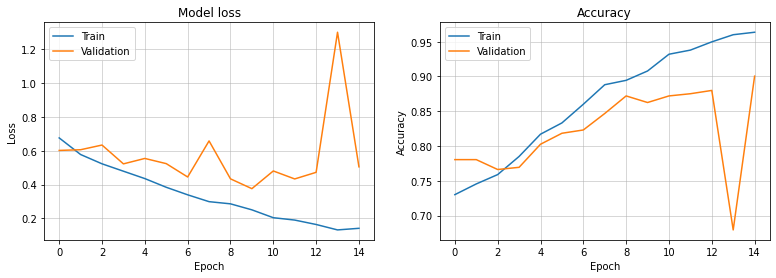

In [44]:
trainer.plot_train_history(history)

In [46]:
trainer.evaluate_model(X_test,y_test)

25/25 [==============================] - 3s 93ms/step - loss: 0.4219 - accuracy: 0.8635


[0.42186999320983887, 0.8634639978408813]

In [54]:
X_eval = X_train[0,:,:]
X_eval

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.0000000e+00,  0.0000000e+00,  1.2578616e-02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.0000000e+00,  0.0000000e+00,  2.5157232e-02],
       ...,
       [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
        -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
       [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
        -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
       [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
        -9.9900000e+02, -9.9900000e+02, -9.9900000e+02]], dtype=float32)

In [55]:
X_eval.shape

(208, 771)

In [50]:
X_eval = X_eval.reshape(1,208,771)

In [51]:
trainer.predict(X_eval)

array([[0.965929]], dtype=float32)

In [56]:
trainer.rtp_input(file_path="../raw_data/Fics_data_pc_data.pgn")

1 games read.
1 games with a total number of 40 moves parsed.


ValueError: in user code:

    File "/Users/manuel/.pyenv/versions/3.8.6/envs/cc_detector/lib/python3.8/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/Users/manuel/.pyenv/versions/3.8.6/envs/cc_detector/lib/python3.8/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/manuel/.pyenv/versions/3.8.6/envs/cc_detector/lib/python3.8/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/manuel/.pyenv/versions/3.8.6/envs/cc_detector/lib/python3.8/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/Users/manuel/.pyenv/versions/3.8.6/envs/cc_detector/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/manuel/.pyenv/versions/3.8.6/envs/cc_detector/lib/python3.8/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 208, 771), found shape=(None, 20, 771)
